# Flood Inundation Mapping
STEPS INVOLVED:
1. Convert the contour data to continuous surface raster (DEM).
2. Map the natural drains

### Explore the contour data

In [1]:
# create folder to save output
import os
basepath = os.path.join(os.getcwd(), "Output")
os.makedirs(basepath, exist_ok=True)

In [3]:
from osgeo import ogr
import warnings
warnings.filterwarnings("ignore")


Data = "https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/flood-inundation-data/Contour_Lines%2C_Sirmaur%2C_Himachal_Pradesh_8192024.gpkg"

# Open the geopackage
shp = ogr.Open(Data)
layer = shp.GetLayer()

# Print attribute names
layer_definition = layer.GetLayerDefn()
print("Attribute names:")
for i in range(layer_definition.GetFieldCount()):
    field_name = layer_definition.GetFieldDefn(i).GetName()
    print(f"- {field_name}")

# Print attributes of the first few features
print("\nAttributes of the first few features:")
for i, feature in enumerate(layer):
    if i >= 5:  # Limit to the first 5 features
        break
    print(f"\nFeature {i + 1}:")
    for j in range(layer_definition.GetFieldCount()):
        field_name = layer_definition.GetFieldDefn(j).GetName()
        field_value = feature.GetField(field_name)
        print(f"  {field_name}: {field_value}")

# Clean up
layer = None
shp = None


Attribute names:
- CATEGORY
- SUBCAT
- TYPE
- C_VALUE
- ADL_INFO

Attributes of the first few features:

Feature 1:
  CATEGORY: 2
  SUBCAT: 1
  TYPE: 1
  C_VALUE: 600.0
  ADL_INFO: HYP_Index_Brown_Contour_Reliable_L_

Feature 2:
  CATEGORY: 2
  SUBCAT: 1
  TYPE: 1
  C_VALUE: 600.0
  ADL_INFO: HYP_Index_Brown_Contour_Reliable_L_

Feature 3:
  CATEGORY: 2
  SUBCAT: 1
  TYPE: 1
  C_VALUE: 800.0
  ADL_INFO: HYP_Index_Brown_Contour_Reliable_L_

Feature 4:
  CATEGORY: 2
  SUBCAT: 1
  TYPE: 1
  C_VALUE: 1200.0
  ADL_INFO: HYP_Index_Brown_Contour_Reliable_L_

Feature 5:
  CATEGORY: 2
  SUBCAT: 1
  TYPE: 1
  C_VALUE: 1200.0
  ADL_INFO: HYP_Index_Brown_Contour_Reliable_L_


### STEP 1: Prepare continous surface raster from contour line

In [4]:
from osgeo import gdal, ogr, osr
import numpy as np
from scipy.interpolate import griddata
import os

# Set your input and output paths
output_tif = os.path.join(basepath, "contour_raster.tif")

# Open the geopackage
shp = ogr.Open(Data)
layer = shp.GetLayer()

# Get extent
x_min, x_max, y_min, y_max = layer.GetExtent()

# Create a blank raster
pixel_size = 30
x_res = int((x_max - x_min) / pixel_size)
y_res = int((y_max - y_min) / pixel_size)

target_ds = gdal.GetDriverByName('GTiff').Create(output_tif, x_res, y_res, 1, gdal.GDT_Float32)
target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))

# Set CRS
spatial_ref = layer.GetSpatialRef()
target_ds.SetProjection(spatial_ref.ExportToWkt())

# Rasterize the layer
gdal.RasterizeLayer(target_ds, [1], layer, options=["ATTRIBUTE=C_VALUE"])

# Read raster band using ReadRaster
band = target_ds.GetRasterBand(1)
buf = band.ReadRaster(0, 0, x_res, y_res, x_res, y_res, gdal.GDT_Float32)
raster_data = np.frombuffer(buf, dtype=np.float32).reshape((y_res, x_res))

# Check if raster_data contains any valid values
if np.isnan(raster_data).all():
    raise ValueError("Raster data contains no valid values. Check the contour attribute and input data.")

# Replace zeros with NaN
raster_data = np.where(raster_data == 0, np.nan, raster_data)

# Prepare interpolation points
x = np.arange(0, raster_data.shape[1])
y = np.arange(0, raster_data.shape[0])
x, y = np.meshgrid(x, y)

points = np.column_stack((x[~np.isnan(raster_data)], y[~np.isnan(raster_data)]))
values = raster_data[~np.isnan(raster_data)]

if points.size == 0 or values.size == 0:
    raise ValueError("No valid points found for interpolation.")

# Interpolate the surface
'''
-----------------------------------------------------------------------------------
For this exercise cubic interpolation is used.
You can also try  nearest and linear.
source: https://docs.scipy.org/doc/scipy/tutorial/interpolate/ND_unstructured.html
------------------------------------------------------------------------------------
'''
raster_data_interp = griddata(points, values, (x, y), method='cubic')

# Restore missing areas with original data
raster_data_interp[np.isnan(raster_data_interp)] = raster_data[np.isnan(raster_data_interp)]

# Convert interpolated array to bytes
raster_bytes = raster_data_interp.astype(np.float32).tobytes()

# Write using WriteRaster
band.WriteRaster(0, 0, x_res, y_res, raster_bytes, x_res, y_res, gdal.GDT_Float32)
band.FlushCache()

# Cleanup
band = None
target_ds = None

print("Rasterization and interpolation completed successfully!")


Rasterization and interpolation completed successfully!


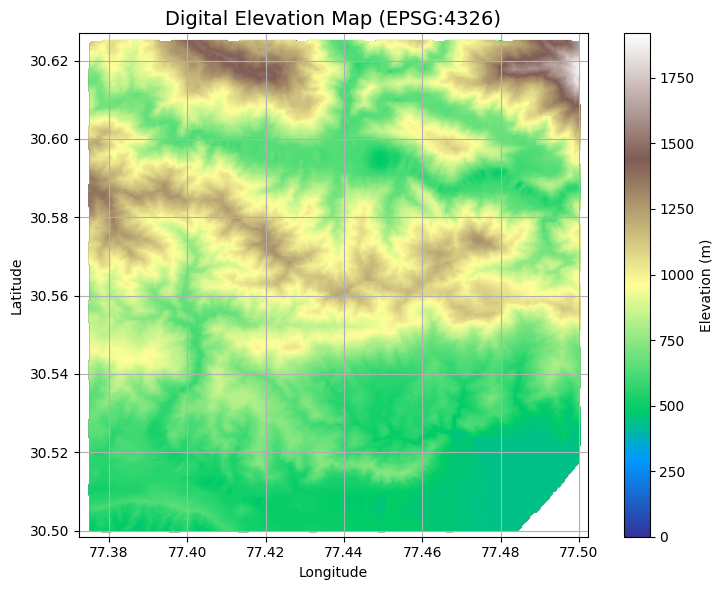

In [5]:
# Visualize the DEM generated
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import os
import tempfile

# Create a temporary raster with NoData set to 0 
temp_file = tempfile.NamedTemporaryFile(suffix=".tif", delete=False)
temp_raster_path = temp_file.name
temp_file.close()

#  Reproject the DEM to EPSG:4326 (WGS 84 - Geographic Coordinate System)
warp_options = gdal.WarpOptions(dstSRS="EPSG:4326", dstNodata=0)
gdal.Warp(temp_raster_path, output_tif, options=warp_options)


# Read the projected temporary DEM raster
ds = gdal.Open(temp_raster_path)
if ds is None:
    raise FileNotFoundError(f"Could not open raster: {temp_raster_path}")

band = ds.GetRasterBand(1)
raster_data = band.ReadRaster(0, 0, ds.RasterXSize, ds.RasterYSize,
                               ds.RasterXSize, ds.RasterYSize, gdal.GDT_Float32)
dem_data = np.frombuffer(raster_data, dtype=np.float32).reshape(ds.RasterYSize, ds.RasterXSize)

# Ensure only true NoData values are masked
dem_data = np.where(dem_data == band.GetNoDataValue(), np.nan, dem_data)

# Compute extent of DEM for plotting
gt = ds.GetGeoTransform()
x_min = gt[0]
y_max = gt[3]
x_max = x_min + ds.RasterXSize * gt[1]
y_min = y_max + ds.RasterYSize * gt[5]
extent = [x_min, x_max, y_min, y_max]

# Plotting the DEM
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

im = ax.imshow(dem_data, extent=extent, cmap='terrain', zorder=1, vmin=0)
cbar = plt.colorbar(im, ax=ax, label='Elevation (m)')
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))

plt.title('Digital Elevation Map (EPSG:4326)', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(zorder=0)
plt.tight_layout()
plt.show()

# Cleanup
band = None
ds = None
os.remove(temp_raster_path)


## FLOOD INUNDATION USING FLOOD FILL ALGORITHM

source code for flood fill algorithm: https://github.com/royalosyin/Work-with-DEM-data-using-Python-from-Simple-to-Complicated/blob/master/ex01-Exploratory%20Flood%20Inundation%20Model%20with%20Flood%20Fill%20Algorithm.ipynb

### a. Flood inundation with one threshold value
(The minimum elevation value in the data is 426.63848876953125 m. So ensure the threshold value specified is larger than minimum elevation.)

___________________________________________________________________________________________________________________________________________
***Flood inundation map is prepared using flood fill algorithm. Assume the areas with elevation < 900m will get inundated. First a binary mask is prepared with DEM as input and conditioned - (DEM < 900, 1, 0). Those cell with DEM values less that 900 will be 1.***

***Then identify the location (sy, sx) the cell with minimum elevation value. This will act as seed cell where the algorithm starts.***

***Then binary mask prepared and the seed cell location (sy, sx) will be input into flood fill algorithm***

***The algorithm starts by checking the 4 neighbours to the seed cell, if the value is 1. The order of check is left (x-1, y), right (x+1, y), down(x, y-1), up(x, y+1) and again fill with values 1 and 0 - denoting inundated or not. All the cells with the the mask is checked progressively. Also inorder to avoid checking previously checked cell - set function is introduced.***
___________________________________________________________________________________________________________________________________________

Minimum Elevation: 426.64 m
Maximum Elevation: 1920.00 m
Starting flood fill...
Flood fill completed.


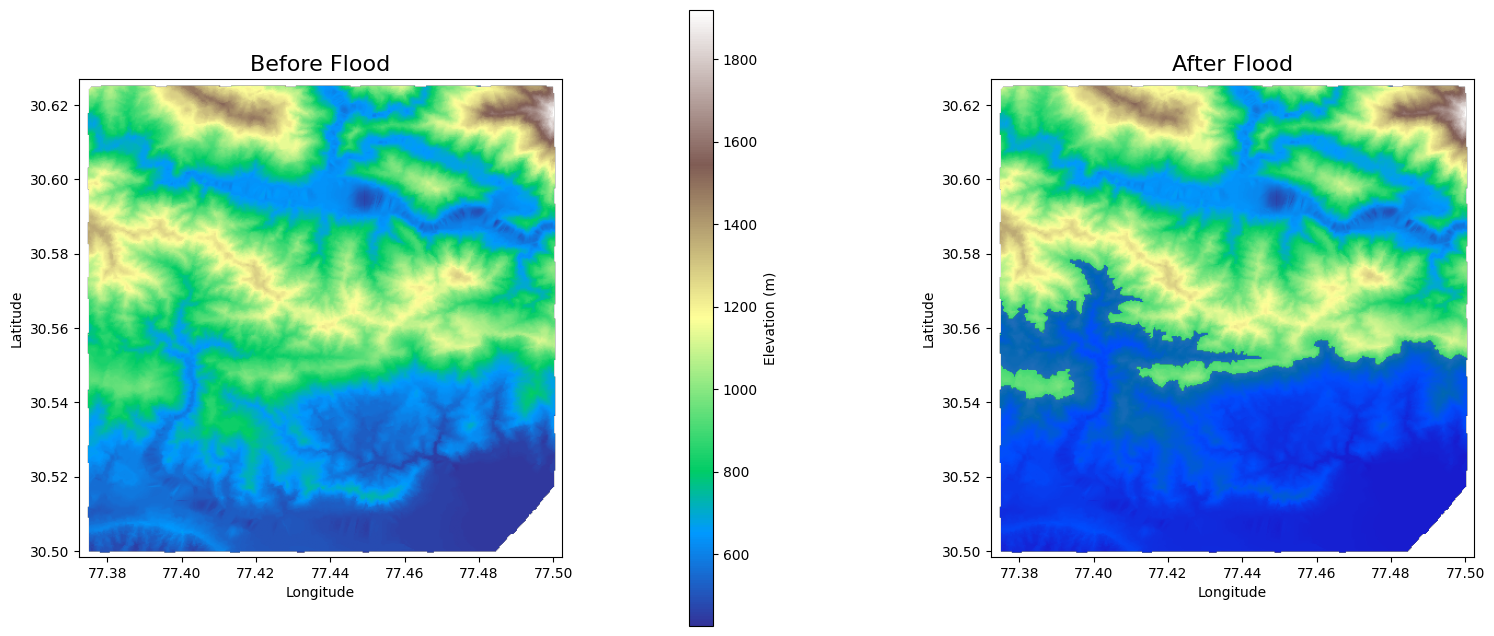

<Figure size 640x480 with 0 Axes>

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
from osgeo import gdal
import tempfile

import warnings
warnings.filterwarnings("ignore")

# Define flood fill method
def floodFill(c, r, mask):
    filled = set()
    fill = set([(c, r)])
    height, width = mask.shape
    flood = np.zeros_like(mask, dtype=np.int8)

    while fill:
        x, y = fill.pop()
        if x < 0 or x >= width or y < 0 or y >= height:
            continue
        if mask[y, x] == 1:
            flood[y, x] = 1
            filled.add((x, y))
            neighbors = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
            for nx, ny in neighbors:
                if (nx, ny) not in filled:
                    fill.add((nx, ny))
    return flood

# Reproject DEM to EPSG:4326 with NoData set to 0
temp_tif = tempfile.NamedTemporaryFile(suffix=".tif", delete=False)
temp_path = temp_tif.name
temp_tif.close()

warp_options = gdal.WarpOptions(dstSRS="EPSG:4326", dstNodata=0)
gdal.Warp(temp_path, output_tif, options=warp_options)

# Load reprojected raster
ds = gdal.Open(temp_path)
band = ds.GetRasterBand(1)
gt = ds.GetGeoTransform()
x_size, y_size = ds.RasterXSize, ds.RasterYSize

# Read raster as bytes and convert to NumPy array
raw_bytes = band.ReadRaster(0, 0, x_size, y_size, x_size, y_size, gdal.GDT_Float32)
dem_data = np.frombuffer(raw_bytes, dtype=np.float32).reshape(y_size, x_size)

# Mask NoData and remove zero-elevation fringe
nodata_val = band.GetNoDataValue() or 0
dem_data = np.where((dem_data == nodata_val) | (dem_data <= 0), np.nan, dem_data)

# Display DEM statistics
print(f"Minimum Elevation: {np.nanmin(dem_data):.2f} m")
print(f"Maximum Elevation: {np.nanmax(dem_data):.2f} m")

# Compute spatial extent for the plot
x_min = gt[0]
y_max = gt[3]
x_max = x_min + x_size * gt[1]
y_min = y_max + y_size * gt[5]
extent = [x_min, x_max, y_min, y_max]

# ----------------------------
# Flood Simulation
# -------------------------
# Define a threshold elevation for flood inundation (e.g., 900m)
threshold = 900
# Start Floodfill from the lowest point in the DEM
sy, sx = np.unravel_index(np.nanargmin(dem_data), dem_data.shape)
mask = np.where(dem_data < threshold, 1, 0)

# Begin the flood fill algorithm
print("Starting flood fill...")
flooded = floodFill(sx, sy, mask)
print("Flood fill completed.")

# Visualization
fig = plt.figure(figsize=(18, 8))
gs = GridSpec(1, 4, width_ratios=[4, 0.2, 0.2, 4])

ax_left = fig.add_subplot(gs[0])
ax_dem_legend = fig.add_subplot(gs[1])
ax_right = fig.add_subplot(gs[3])

dem_plot = ax_left.imshow(dem_data, cmap='terrain', extent=extent)
ax_left.set_title('Before Flood', fontsize=16)
ax_left.set_xlabel("Longitude")
ax_left.set_ylabel("Latitude")

ax_right.imshow(dem_data, cmap='terrain', extent=extent)
flood_cmap = ListedColormap(['none', 'blue'])
ax_right.imshow(flooded, cmap=flood_cmap, alpha=0.5, extent=extent)
ax_right.set_title('After Flood', fontsize=16)
ax_right.set_xlabel("Longitude")
ax_right.set_ylabel("Latitude")

fig.colorbar(dem_plot, cax=ax_dem_legend, orientation='vertical', label='Elevation (m)')
plt.subplots_adjust(wspace=0.5)
plt.show()

# Save the output and cleanup
plt.savefig(os.path.join(basepath, "Flood inundation.png"))
band = None
ds = None
os.remove(temp_path)

### b. Flood inundation for a list of threshold value
(Animation is generated by running flood fill algorithm for different threshold value in each frame. Then animates using the frames and saves as html file. The same html opens in a new browser)

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML
from osgeo import gdal
import tempfile

import warnings
warnings.filterwarnings("ignore")

# Define flood fill method
def floodFill(c, r, mask):
    filled = set()
    fill = set([(c, r)])
    height, width = mask.shape
    flood = np.zeros_like(mask, dtype=np.int8)

    while fill:
        x, y = fill.pop()
        if x < 0 or x >= width or y < 0 or y >= height:
            continue
        if mask[y, x] == 1:
            flood[y, x] = 1
            filled.add((x, y))
            neighbors = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
            for nx, ny in neighbors:
                if (nx, ny) not in filled:
                    fill.add((nx, ny))
    return flood

# Reproject raster to EPSG:4326 and set NoData=0
temp_tif = tempfile.NamedTemporaryFile(suffix=".tif", delete=False)
temp_path = temp_tif.name
temp_tif.close()

warp_options = gdal.WarpOptions(dstSRS="EPSG:4326", dstNodata=0)
gdal.Warp(temp_path, output_tif, options=warp_options)

# Read reprojected raster
ds = gdal.Open(temp_path)
band = ds.GetRasterBand(1)
gt = ds.GetGeoTransform()
x_size, y_size = ds.RasterXSize, ds.RasterYSize

raw_bytes = band.ReadRaster(0, 0, x_size, y_size, x_size, y_size, gdal.GDT_Float32)
dem_data = np.frombuffer(raw_bytes, dtype=np.float32).reshape(y_size, x_size)

# Mask NoData and zero elevation values
nodata_val = band.GetNoDataValue() or 0
dem_data = np.where((dem_data == nodata_val) | (dem_data <= 0), np.nan, dem_data)

# Get the extent of DEM for plotting
x_min = gt[0]
y_max = gt[3]
x_max = x_min + x_size * gt[1]
y_min = y_max + y_size * gt[5]
extent = [x_min, x_max, y_min, y_max]

# ------------------------------------------
# FLOOD SIMULATION
# ------------------------------------------
# Define threshold values
thresholds = [500, 550, 600, 650, 700, 750, 800, 850, 900] # Replace with the threshold values of your choice
# Find the lowest point in the DEM to start flood fill
sy, sx = np.unravel_index(np.nanargmin(dem_data), dem_data.shape)

# Setup animation canvas
fig, ax = plt.subplots(figsize=(10, 8))
divider = make_axes_locatable(ax)
cax_dem = divider.append_axes("right", size="5%", pad=0.1)
flood_cmap = ListedColormap(['none', 'blue'])

# Function to update each frame in the animation
def update(threshold):
    ax.clear()
    mask = np.where(dem_data < threshold, 1, 0)
    flooded = floodFill(sx, sy, mask)

    dem_plot = ax.imshow(dem_data, cmap='terrain', vmin=np.nanmin(dem_data),
                         vmax=np.nanmax(dem_data), extent=extent)

    ax.imshow(flooded, cmap=flood_cmap, alpha=0.5, extent=extent)

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f'After Flood (Threshold: {threshold}m)', fontsize=16)

    fig.colorbar(dem_plot, cax=cax_dem, orientation='vertical', label='Elevation (m)')

# Create animation and render HTML
ani = FuncAnimation(fig, update, frames=thresholds, repeat=True)
html_animation = HTML(ani.to_jshtml())

plt.close(fig)
band = None
ds = None
os.remove(temp_path)

html_animation  # Display animation
